# <center> Yelp! Customer Reviews Analytics</center>



# Introduction:
Online reviews and customer feedback can give businesses great insights in order to improve their business model. Even though review-like data is readily availabe and easily accessible on social media platforms, there is not an easy solution to analyze the unstructred data. 

In this project, reviews of coffee shopes/cafes in Manhattan are studied by using many different techniques to understand what are the factors that cause customers to be satisfied or disatisfied. Insights from this study can help business owners to improve customer satisfaction, as well as their revenues. 


## Review length study

(4370, 6)


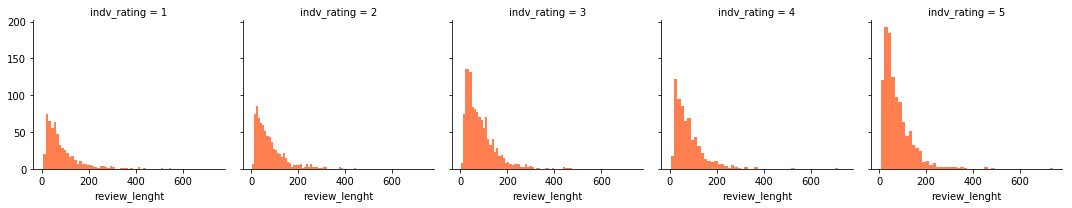

<Figure size 432x288 with 0 Axes>

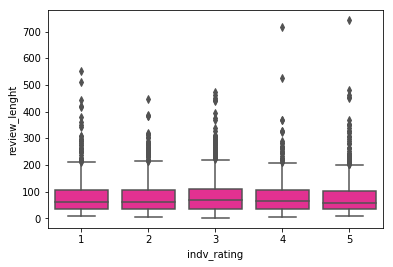

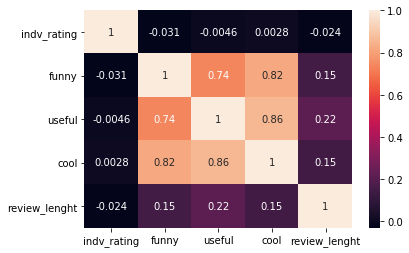

In [15]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import numpy as np

# Create function to count the lenght of words.
def count_lenght(text):
    return len(text.split())

def EDA(file):
    yelp_df = pd.read_csv(file, encoding = "latin1")
    yelp_df['review_lenght'] = yelp_df['review'].apply(count_lenght)

    yelp_data = yelp_df[['review', 'indv_rating','funny', 'useful', 'cool', 'review_lenght']]
    print(yelp_data.shape)
    star_hist = sns.FacetGrid(data = yelp_df, col = 'indv_rating')

    # histogram for the ratings
    plt.figure()
    star_hist.map(plt.hist, 'review_lenght', bins = 50, color = 'coral')

    #box plot for individual ratings against the review-lenght 
    plt.figure()
    sns.boxplot(x = 'indv_rating', y = 'review_lenght', data = yelp_df, color = 'deeppink')

    #.corr() calculates the correlation
    # heat map for to find out the corelation between the cool, useful, funny, and text length
    plt.figure()
    sns.heatmap(data=yelp_df[['review', 'indv_rating', 'funny', 'useful', 'cool', 'review_lenght']].corr(), annot=True)

#Call function.    
file = r'review.csv'
EDA(file)


## Order Tranding Analytics 

- This section is to study differences of order in each seasons in order to answer some of the questions such as are there differences of drinks ordered in winter and summer? and what do customers order more in winter than in summer?

In [77]:
# import data.
df= pd.read_csv('Review_data_entire.csv',header=0, encoding='latin1')

# create new colums for each season if months match conditions.
df['winter'] = df['review_date'].apply(lambda x : 'winter' if re.findall(r'^\d*', x)[0] in ['12','1','2'] else np.nan)
df['summer'] = df['review_date'].apply(lambda x : 'summer' if re.findall(r'^\d*', x)[0] in ['6','7','8'] else np.nan)
df['fall'] = df['review_date'].apply(lambda x : 'fall' if re.findall(r'^\d*', x)[0] in ['9','10','11'] else np.nan)
df['spring'] = df['review_date'].apply(lambda x : 'spring' if re.findall(r'^\d*', x)[0] in ['3','4','5'] else np.nan)

In [91]:
import re
import nltk
import string


def get_bigrams_all_review(df, N):
    
    # a list of negative words
    negations = ['no','nor','not','too','don',"don't",'ain','aren',"aren't",'couldn',"couldn't",\
    'didn',"didn't",'doesn','isn',"isn't",'wasn',"wasn't",'weren',"weren't"]
    
    # Call stopwords and remove negative words from them
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words = [word for word in stop_words if not word in negations]
    
    # Get a list of all reviews
    list_of_reviews = df.review.values.tolist()
    
    # Get a string of text
    text = " ".join(list_of_reviews).lower()
    
    # Create pattern
    pattern=r'\w[\w\'-]*\w'                        
    # Get tokens
    tokens = nltk.regexp_tokenize(text, pattern)
    # Remove stopwords from tokens
    filtered_tokens = [token for token in tokens if not token in stop_words]
    # Get bigrams
    bigrams=list(nltk.bigrams(filtered_tokens))
    # get freqent bigrams    
    frequent_bigram = {bigram:bigrams.count(bigram) for bigram in set(bigrams)}
    
    # return top N frequent bigrams
    return sorted(frequent_bigram.items(), key=lambda x: x[1])[::-1][:N]

In [87]:
# Get a bar chart for frequent words. 
def get_chart_frequent_word(bigrams_winter_frequent, title):
    
    sns.set_style("whitegrid");

    plt.figure(figsize=(8,5))
    sns.barplot(x='Frequency',y='Bigrams', data=bigrams_winter_frequent)
    plt.xticks(rotation=(90))
    plt.title(title)
    plt.show()


In [93]:
# Get lists of frequent bigrams.
bigrams_winter = get_bigrams_all_review(df[df['winter']=='winter'], 30)

In [94]:
bigrams_summer = get_bigrams_all_review(df[df['summer']=='summer'], 30)

In [95]:
# Create dataframes for lists of bigrams.
bigrams_winter_frequent = pd.DataFrame(bigrams_winter)
bigrams_winter_frequent.columns=["Bigrams", "Frequency"]
bigrams_summer_frequent = pd.DataFrame(bigrams_summer)
bigrams_summer_frequent.columns=["Bigrams", "Frequency"]

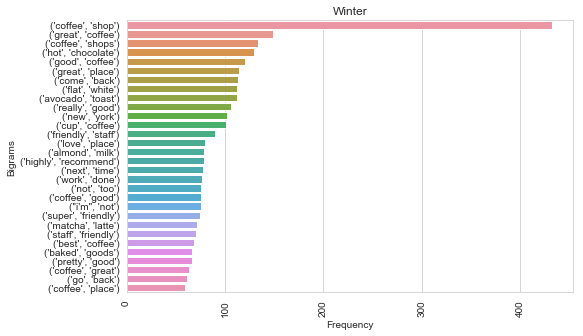

None


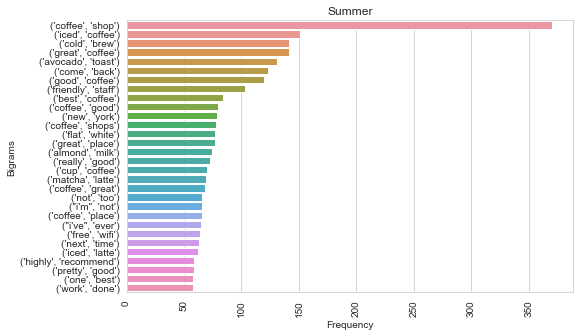

None


In [96]:
# call function to create bar graphs.
print (get_chart_frequent_word(bigrams_winter_frequent, "Winter"))
print (get_chart_frequent_word(bigrams_summer_frequent, "Summer"))

# Topics Classification.


In [97]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
import numpy as np

# Topic Classification without Gridsearch

## Multinomial Naive Bayes

In [116]:
# define a function to evaluate NB model.
def NB_topic_classification(train_file_name):
    # import dataset.
    categ_data = pd.read_csv(train_file_name , header = 0)    
    classes = categ_data.label.values
    classes = [i.split(",") for i in classes]
    # one hot encoding
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(classes)
    
    # split dataset into traning and testing.
    X_train, X_test, Y_train, Y_test = train_test_split(\
                    categ_data.review, Y, test_size=0.3, random_state=0)
    
    # create a pipeline to vectorize and classify.
    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english",\
                                  min_df=2)),
        ('clf', OneVsRestClassifier(MultinomialNB(alpha = 0.5 )))])
    
    # train model with training part of the datastet.
    classifier.fit(X_train, Y_train)
    
    # predict testing data and store them
    predicted = classifier.predict(X_test)

    predicted.shape
    # compare predicted with the ground truth and report performance.
    print(classification_report\
          (Y_test, predicted, target_names=mlb.classes_))  

In [117]:
NB_topic_classification("label restaurant data.csv" )

                         precision    recall  f1-score   support

               ambience       0.95      0.29      0.44       140
anecdotes/miscellaneous       0.74      0.56      0.64       342
                   food       0.83      0.72      0.77       366
                  price       0.93      0.36      0.52       102
                service       0.86      0.50      0.64       173

              micro avg       0.82      0.55      0.66      1123
              macro avg       0.86      0.49      0.60      1123
           weighted avg       0.83      0.55      0.65      1123
            samples avg       0.62      0.58      0.59      1123



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Support Vector Machine

In [101]:
# This function is to evaluate SVM model.
# The code is referenced from the NB model eveluation above;
# however, the model has changed to SVM in the pipeline definition.

def SVM_topic_classification(train_file_name):
    
    categ_data = pd.read_csv(train_file_name , header = 0)    
    classes = categ_data.label.values
    classes = [i.split(",") for i in classes]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(classes)

    X_train, X_test, Y_train, Y_test = train_test_split(\
                    categ_data.review, Y, test_size=0.3, random_state=0)

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english",\
                                  min_df=2)),
        ('clf', OneVsRestClassifier(LinearSVC(C = 1)))])

    classifier.fit(X_train, Y_train)

    predicted = classifier.predict(X_test)

    predicted.shape
    
    print(classification_report\
          (Y_test, predicted, target_names=mlb.classes_))  

In [102]:
SVM_topic_classification("label restaurant data.csv")

                         precision    recall  f1-score   support

               ambience       0.87      0.54      0.66       140
anecdotes/miscellaneous       0.71      0.73      0.72       342
                   food       0.85      0.80      0.82       366
                  price       0.88      0.74      0.80       102
                service       0.85      0.70      0.77       173

              micro avg       0.80      0.73      0.76      1123
              macro avg       0.83      0.70      0.76      1123
           weighted avg       0.81      0.73      0.76      1123
            samples avg       0.74      0.73      0.72      1123



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## K-nearest neighbour

In [110]:
# This function is to evaluate KNN model.
# The code is referenced from the NB model eveluation above;
# however, the model has changed to KNN in the pipeline definition.


def KNN_topic_classification(train_file_name):
    
    categ_data = pd.read_csv(train_file_name , header = 0)    
    classes = categ_data.label.values
    classes = [i.split(",") for i in classes]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(classes)

    X_train, X_test, Y_train, Y_test = train_test_split(\
                    categ_data.review, Y, test_size=0.3, random_state=0)

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english",\
                                  min_df=2)),
        ('clf', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=1)))])

    classifier.fit(X_train, Y_train)

    predicted = classifier.predict(X_test)

    predicted.shape
    
    print(classification_report\
          (Y_test, predicted, target_names=mlb.classes_))  
    

In [111]:
KNN_topic_classification("label restaurant data.csv" )

                         precision    recall  f1-score   support

               ambience       0.67      0.11      0.20       140
anecdotes/miscellaneous       0.42      0.87      0.57       342
                   food       0.73      0.25      0.37       366
                  price       0.75      0.29      0.42       102
                service       0.56      0.23      0.33       173

              micro avg       0.49      0.42      0.46      1123
              macro avg       0.63      0.35      0.38      1123
           weighted avg       0.60      0.42      0.41      1123
            samples avg       0.49      0.46      0.46      1123



# Topic Classification with Gridsearch

In [48]:
categ_data = pd.read_csv("label restaurant data.csv" , header = 0)   
categ_data.head()
classes = categ_data.label.values
classes = [i.split(",") for i in classes]


In [ ]:
# implement one hot encoding.
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(classes)

classes_label = mlb.classes_


ambience = Y[:,0]
food = Y[:,2]
miscellaneous = Y[:,1]
service = Y[:,4]
price = Y[:,3]
                

## Topic Classification using Multinomial Naive Bayes.

In [54]:

def NB_topic_classification(review_data, feature):
    

    X_train, X_test, y_train, y_test = train_test_split(review_data, feature , \
                                                        test_size=0.25, random_state=0)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__max_df': [0.995 , 0.999, 1.0],
                  'tfidf__stop_words':[None,"english"],
                  'clf__alpha': [0.5, 1.0, 2.0 , 5.0]}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)


    gs_clf = gs_clf.fit(X_train, y_train)

    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_alpha = gs_clf.best_params_["clf__alpha"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_max_df = gs_clf.best_params_["tfidf__max_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df, max_df = tfidf_max_df)),
        ('clf', MultinomialNB(alpha = clf_alpha ))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(np.unique(feature))
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    
    return predicted

    

In [55]:
predicted_ambience =  NB_topic_classification(categ_data.review, ambience)
predicted_miscellaneous=  NB_topic_classification(categ_data.review, miscellaneous)
predicted_food =  NB_topic_classification(categ_data.review, food)
predicted_price =  NB_topic_classification(categ_data.review, price)
predicted_service =  NB_topic_classification(categ_data.review, service)

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.6700712153057082
clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 2
tfidf__stop_words : None
best f1 score: 0.7691840515799927
clf__alpha : 1.0
tfidf__max_df : 0.995
tfidf__min_df : 2
tfidf__stop_words : english
best f1 score: 0.8255765748894235


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.668024906667693


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf__alpha : 0.5
tfidf__max_df : 0.995
tfidf__min_df : 3
tfidf__stop_words : english
best f1 score: 0.7959727136933766


In [57]:
X_train, X_test, y_train, y_test = train_test_split(categ_data.review, Y , \
                                                    test_size=0.25, random_state=0)

zip_all = list(zip(predicted_ambience, predicted_miscellaneous, predicted_food, predicted_price, predicted_service))

print(classification_report\
      (y_test, np.array(list(zip_all)), target_names=mlb.classes_)) 

                         precision    recall  f1-score   support

               ambience       0.95      0.30      0.45       121
anecdotes/miscellaneous       0.78      0.56      0.65       289
                   food       0.86      0.70      0.77       301
                  price       0.97      0.41      0.58        80
                service       0.88      0.56      0.68       145

              micro avg       0.85      0.56      0.67       936
              macro avg       0.89      0.50      0.63       936
           weighted avg       0.86      0.56      0.66       936
            samples avg       0.62      0.59      0.60       936



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Topic Classification using Support Vector Machine

In [56]:

def SVM_topic_classification(review_data, feature):
    

    X_train, X_test, y_train, y_test = train_test_split(review_data, feature , \
                                                        test_size=0.25, random_state=0)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__max_df': [0.995 , 0.999 , 1.0],
                  'tfidf__stop_words':[None,"english"],
                  'clf__C':[ 1, 2, 5],
                 'clf__kernel':['linear']}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)


    gs_clf = gs_clf.fit(X_train, y_train)

    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_C = gs_clf.best_params_["clf__C"]
    clf_kernel = gs_clf.best_params_["clf__kernel"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_max_df = gs_clf.best_params_["tfidf__max_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df, max_df = tfidf_max_df)),
        ('clf', svm.SVC(C = clf_C, kernel = clf_kernel))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(np.unique(feature))
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    
    return predicted


In [58]:
predicted_ambience =  SVM_topic_classification(categ_data.review, ambience)
predicted_miscellaneous=  SVM_topic_classification(categ_data.review, miscellaneous)
predicted_food =  SVM_topic_classification(categ_data.review, food)
predicted_price =  SVM_topic_classification(categ_data.review, price)
predicted_service =  SVM_topic_classification(categ_data.review, service)

clf__C : 2
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.8115904458156638
clf__C : 1
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7991135102581619
clf__C : 1
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.8666034900184318
clf__C : 2
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.8534716551437846
clf__C : 2
clf__kernel : linear
tfidf__max_df : 0.995
tfidf__min_df : 1
tfidf__stop_words : english
best f1 score: 0.8787895157563381


In [59]:
X_train, X_test, y_train, y_test = train_test_split(categ_data.review, Y , \
                                                    test_size=0.25, random_state=0)

zip_all = list(zip(predicted_ambience, predicted_miscellaneous, predicted_food, predicted_price, predicted_service))

print(classification_report\
      (y_test, np.array(list(zip_all)), target_names=mlb.classes_)) 

                         precision    recall  f1-score   support

               ambience       0.83      0.56      0.67       121
anecdotes/miscellaneous       0.77      0.69      0.73       289
                   food       0.86      0.76      0.81       301
                  price       0.89      0.79      0.83        80
                service       0.84      0.74      0.79       145

              micro avg       0.83      0.71      0.77       936
              macro avg       0.84      0.71      0.77       936
           weighted avg       0.83      0.71      0.76       936
            samples avg       0.72      0.71      0.70       936



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Topic Classification using K-Nearest Neighbour

In [61]:

def KNN_topic_classification(review_data, feature):
    

    X_train, X_test, y_train, y_test = train_test_split(review_data, feature , \
                                                        test_size=0.25, random_state=0)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])
    
    k_range = list(range(1, 10))

    parameters = {'tfidf__min_df':[1, 2, 3],
                  'tfidf__stop_words':[None,"english"],
                  'clf__n_neighbors': k_range}

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)


    gs_clf = gs_clf.fit(X_train, y_train)

    for param_name in gs_clf.best_params_:
        print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
    print("best f1 score:", gs_clf.best_score_)

    clf_k = gs_clf.best_params_["clf__n_neighbors"]
    tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
    tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]

    classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                                  min_df=tfidf_min_df)),
        ('clf', KNeighborsClassifier(n_neighbors= clf_k))])

    clf = classifier.fit(X_train,  y_train)

    labels=sorted(np.unique(feature))
    labels = list(map(str, labels))

    predicted = classifier.predict(X_test)
    
    return predicted

In [62]:
predicted_ambience =  KNN_topic_classification(categ_data.review, ambience)
predicted_miscellaneous= KNN_topic_classification(categ_data.review, miscellaneous)
predicted_food =  KNN_topic_classification(categ_data.review, food)
predicted_price =  KNN_topic_classification(categ_data.review, price)
predicted_service =  KNN_topic_classification(categ_data.review, service)

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

clf__n_neighbors : 1
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.6425241878899145
clf__n_neighbors : 7
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7457807382419082
clf__n_neighbors : 9
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7878170595889145


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sukit\Anaconda2

clf__n_neighbors : 3
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7020501053173683


C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


clf__n_neighbors : 9
tfidf__min_df : 1
tfidf__stop_words : None
best f1 score: 0.7561740766316658


In [63]:
X_train, X_test, y_train, y_test = train_test_split(categ_data.review, Y , \
                                                    test_size=0.25, random_state=0)

zip_all = list(zip(predicted_ambience, predicted_miscellaneous, predicted_food, predicted_price, predicted_service))

print(classification_report\
      (y_test, np.array(list(zip_all)), target_names=mlb.classes_)) 

                         precision    recall  f1-score   support

               ambience       0.61      0.31      0.41       121
anecdotes/miscellaneous       0.71      0.68      0.70       289
                   food       0.77      0.68      0.72       301
                  price       0.78      0.44      0.56        80
                service       0.79      0.48      0.60       145

              micro avg       0.74      0.58      0.65       936
              macro avg       0.73      0.52      0.60       936
           weighted avg       0.73      0.58      0.64       936
            samples avg       0.64      0.62      0.61       936



C:\Users\sukit\Anaconda2\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Feature classification using SVM (Best Performance)

In [82]:
All_review_to_classify = pd.read_csv("Review_data_entire.csv")
All_review_to_classify = All_review_to_classify.review

def feature_classification(reviews):
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])

    labels=sorted(np.unique(ambience))
    labels = list(map(str, labels))


    ambience_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= "english", min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 2, kernel = 'linear'))])

    ambience_clf = ambience_classifier.fit(categ_data.review, ambience)

    ambience_predicted = ambience_classifier.predict(reviews)


    miscel_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= None, min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 1, kernel = 'linear'))])

    miscel_clf = miscel_classifier.fit(categ_data.review, miscellaneous)

    miscel_predicted = miscel_classifier.predict(reviews)


    food_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= None, min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 1, kernel = 'linear'))])

    food_clf = food_classifier.fit(categ_data.review, food)

    food_predicted = food_classifier.predict(reviews)


    price_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= "english", min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 2, kernel = 'linear'))])

    price_clf = price_classifier.fit(categ_data.review, price)

    price_predicted = price_classifier.predict(reviews)


    service_classifier = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words= "english", min_df=1, max_df = 0.995)),
        ('clf', svm.SVC(C = 2, kernel = 'linear'))])

    service_clf = service_classifier.fit(categ_data.review, service)

    service_predicted = service_classifier.predict(reviews)
    
    combined_classes = np.array(list(zip(ambience_predicted, miscel_predicted, \
                                     food_predicted, price_predicted, service_predicted)))
    return combined_classes



(-1.2229578053589671,
 1.1058551711064004,
 -1.1016406590145102,
 1.1069526886468897)

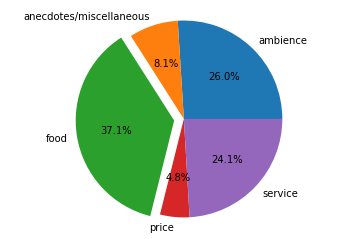

In [93]:
combined_classes = feature_classification(All_review_to_classify)

count_classes = np.sum(combined_classes , axis=0)


fig1, ax1 = plt.subplots()
ax1.pie(count_classes, explode= (0, 0, 0.1, 0 , 0) , labels = mlb.classes_ ,autopct='%1.1f%%')
ax1.axis('equal')


## Sentiment Analysis using VADER

In [76]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    

    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    if sentiment_dict['compound'] >= 0.5 : 
        return "Positive"
  
    elif sentiment_dict['compound'] <= - 0.5 : 
        return "Negative"
  
    else : 
        return "Neutral"

In [79]:
all_review_df = pd.read_csv("Review_data_entire.csv")
all_review_df = all_review_df['review']


In [80]:
sentiment_df = all_review_df.apply(sentiment_scores)
analyze_df = pd.DataFrame(pd.concat([all_review_df, sentiment_df], axis = 1 ))
analyze_df.columns = ["review" , "sentiment"]
analyze_df.head()

,review,sentiment
0,"Kept passing by this new cafe, and finally ste...",Positive
1,Edited to add: This place has CBD coffee drink...,Positive
2,A place that seems to actually live up to its ...,Positive
3,Love this place. They have oat milk! Brown su...,Positive
4,Promising new coffee shop that just opened in ...,Positive


Text(0.5, 1.0, 'Sentiment of all reviews')

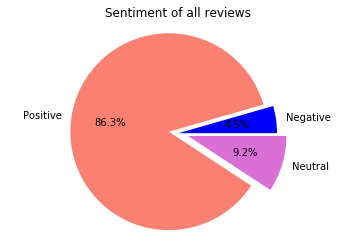

In [81]:
num_neg = analyze_df[analyze_df.sentiment == "Negative"].count().values[1]
num_pos = analyze_df[analyze_df.sentiment == "Positive"].count().values[1]
num_neu = analyze_df[analyze_df.sentiment == "Neutral"].count().values[1]

fig1, ax1 = plt.subplots()
color = ["b" , "salmon", "orchid"]
ax1.pie([num_neg , num_pos , num_neu], explode= (0, 0.1, 0.1) , \
        colors=color , labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Sentiment of all reviews")


## Negative Review Analytics (For all review in dataset)

In [84]:
negative_review = analyze_df[analyze_df.sentiment == "Negative"]

Text(0.5, 1.0, 'Number of each feature in Negative review')

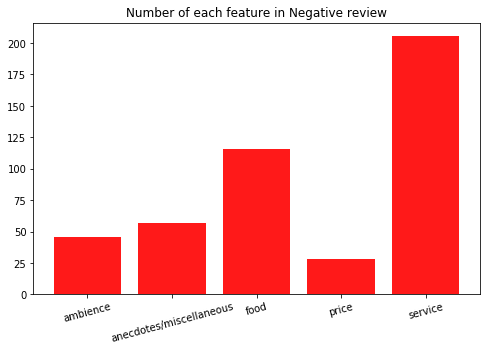

In [94]:
combined_classes = feature_classification(negative_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "r")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Negative review")



## Positive Review Analytics (for all reviews in dataset)

In [95]:
positive_review = analyze_df[analyze_df.sentiment == "Positive"]

Text(0.5, 1.0, 'Number of each feature in Negative review')

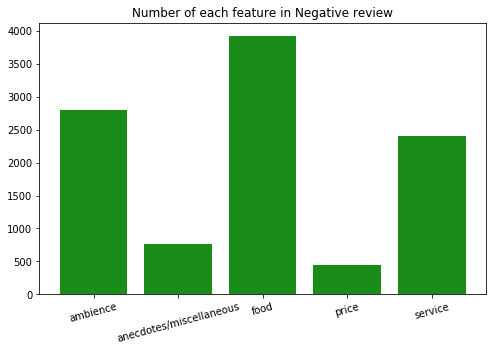

In [96]:
combined_classes = feature_classification(positive_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "g")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Negative review")


# Applications of Model

## Alice's Tea cup Chapter

In [99]:
alice_cafe = pd.read_csv("Cafe_analyze_data.csv")
alice_cafe = alice_cafe.review


In [100]:
sentiment_alice_review = alice_cafe.apply(sentiment_scores)

Text(0.5, 1.0, "Alice's Tea cafe Sentiment")

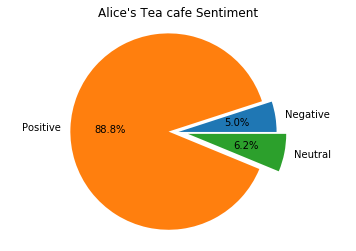

In [101]:
analyze_alice = pd.DataFrame(pd.concat([alice_cafe, sentiment_alice_review], axis = 1 ))
analyze_alice.columns = ["review" , "sentiment"]

alice_num_neg = analyze_alice[analyze_alice.sentiment == "Negative"].count().values[1]
alice_num_pos = analyze_alice[analyze_alice.sentiment == "Positive"].count().values[1]
alice_num_neu = analyze_alice[analyze_alice.sentiment == "Neutral"].count().values[1]

fig1, ax1 = plt.subplots()
ax1.pie([alice_num_neg , alice_num_pos , alice_num_neu], explode= (0, 0.1, 0.1) , labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Alice's Tea cafe Sentiment")

## Alice's Tea cup Chapter Possitive Reviews

Text(0.5, 1.0, "Number of each feature in Alice's tea Cafe Positive review")

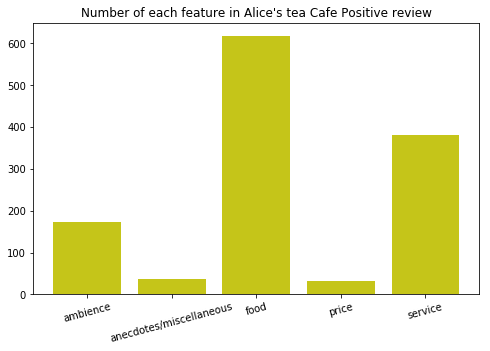

In [103]:
positive_alice_review = analyze_alice[analyze_alice.sentiment == "Positive"]

combined_classes = feature_classification(positive_alice_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "y")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Alice's tea Cafe Positive review")


## Alice's Tea cup Chapter Negative Reviews

Text(0.5, 1.0, "Number of each feature in Alice's tea Cafe Negative review")

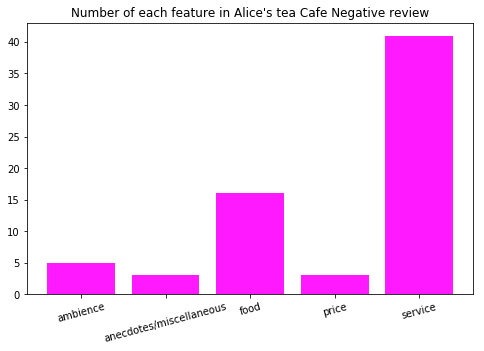

In [104]:
Negative_alice_review = analyze_alice[analyze_alice.sentiment == "Negative"]

combined_classes = feature_classification(Negative_alice_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "fuchsia")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Alice's tea Cafe Negative review")


# Saltwater Coffee

In [105]:
Saltwater_df = pd.read_csv("Review_data_entire.csv")
Saltwater_df = Saltwater_df[Saltwater_df['cafe_name'] == "Saltwater Coffee"].review

In [106]:
sentiment_saltwater_review = Saltwater_df.apply(sentiment_scores)

In [107]:
analyze_saltwater = pd.DataFrame(pd.concat([Saltwater_df, sentiment_saltwater_review], axis = 1 ))
analyze_saltwater.columns = ["review" , "sentiment"]

In [108]:
salt_num_neg = analyze_saltwater[analyze_saltwater.sentiment == "Negative"].count().values[1]
salt_num_pos = analyze_saltwater[analyze_saltwater.sentiment == "Positive"].count().values[1]
salt_num_neu = analyze_saltwater[analyze_saltwater.sentiment == "Neutral"].count().values[1]

Text(0.5, 1.0, 'Saltwater cafe Sentiment')

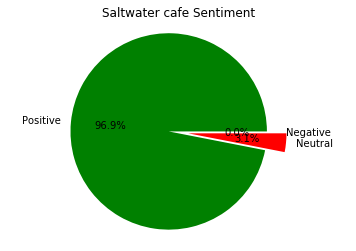

In [109]:
fig1, ax1 = plt.subplots()
color_salt = ["magenta" , "g", "r"]
ax1.pie([salt_num_neg , salt_num_pos , salt_num_neu], explode= (0, 0.1, 0.1) , \
        colors = color_salt,labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Saltwater cafe Sentiment")

## Salt Coffee Positive Review Analytics 

In [110]:
positive_salt_review = analyze_saltwater[analyze_saltwater.sentiment == "Positive"]

Text(0.5, 1.0, 'Number of each feature in Saltwater Cafe Positive review')

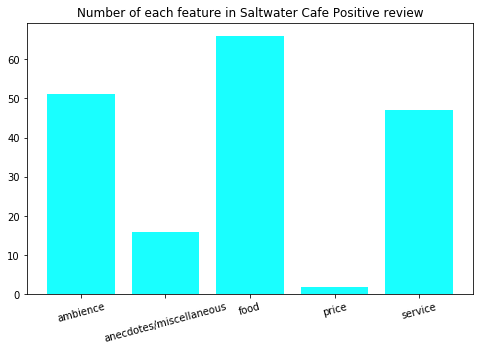

In [111]:
combined_classes = feature_classification(positive_salt_review.review)

count_classes = np.sum(combined_classes , axis=0)

y_pos = np.arange(len(mlb.classes_))

plt.figure(figsize=(8,5))
plt.bar(y_pos , count_classes, align='center', alpha=0.9, color = "cyan")
plt.xticks(y_pos, mlb.classes_, rotation = 15)
plt.title("Number of each feature in Saltwater Cafe Positive review")